# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

First, I needed to generate a description of the variables in the data. I started by focusing on the existing customers when profiling. 

In [2]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [3]:
# Utility for looking at column-level information
def df_desc(in_df):
    """Generate dataframe with column-level information about a file"""
    cols = list(in_df.columns)
    df_rows = []
    for col in cols:
        ser = in_df[col]
        desc = ser.describe()
        na_cnt = pd.Series(ser.isna().sum(), index=['NAs'])
        desc = desc.append(na_cnt)
        df_rows.append(desc)
    
    out_df = pd.DataFrame(df_rows, index=cols)
    return out_df

descs = df_desc(customers)
descs.to_csv('variables_descs.csv')
descs.head()

,count,mean,std,min,25%,50%,75%,max,NAs,unique,top,freq
LNR,191652.0,95826.500000,55325.311233,1.0,47913.75,95826.5,143739.25,191652.0,0.0,NaN,NaN,NaN
AGER_TYP,191652.0,0.344359,1.391672,-1.0,-1.00,0.0,2.00,3.0,0.0,NaN,NaN,NaN
AKT_DAT_KL,145056.0,1.747525,1.966334,1.0,1.00,1.0,1.00,9.0,46596.0,NaN,NaN,NaN
ALTER_HH,145056.0,11.352009,6.275026,0.0,8.00,11.0,16.00,21.0,46596.0,NaN,NaN,NaN
ALTER_KIND1,11766.0,12.337243,4.006050,2.0,9.00,13.0,16.00,18.0,179886.0,NaN,NaN,NaN


I ended up doing a lot of the variable exploration manually, but here are the main things I found: 
    
* Several values were missing from the data dictionaries provided. Given their importance for
interpreting values (are they ordered or are they unstructured categories?), I decided to 
exclude those variables out of hand.
* There were several values that were coded as missing, with the interpretation differeing
among variables. There were also outright missing values. I ended up converting all coded missing
values as NaN to treat them the same way.
* Some variables were missing from a lot of records. There were also groups of variables were all 
missing from the same set of records, meaning they likely came from the same data source. In a few
particularly egregrious cases I dumped the entire variable; in others I'd designate one variable 
out of the set to have a flag for whether it was missing from a record, thenignore nulls for all 
other cases.
* Some variables could summarize the results of several other variables. For instance, there were
multiple ratings for the abundance of different car types, and then another variable that identified
the most common type. When these relationships were obvious, I would take the more parsimonious
variable.
* A lot of variables could be interpreted ordinally (e.g. ranging from "very unlikely" to "very 
likely"). By using a tree method, I could treat these as a numerical variable instead of having
to make separate dummies for each level. Not all variables fit into a clear monotonic hierarchy
though, so I had to be deliberate about classifying them.

For ease of processing and documentation, I wrote the file `variable_eval.csv`, which held all
of the information for how to process variables during the cleaning process. 

In [4]:
# Information about variables to keep and modify
# Built manually by comparing the two data dictionaries
var_eval = pd.read_csv('variable_eval.csv')
var_eval = var_eval.loc[var_eval.exclude != 1]
var_eval.set_index('variable', inplace=True)

In [5]:
def df_clean(in_df, var_eval, med_dict=dict()):
    """Clean data and change types, as needed
    Arguments:
        in_df - Dataframe to claen
        var_eval - Dataframe with indicators for how to handle a column
        med_dict - Dictionary of pre-computed median values for filling NAs
    """
    
    # Eliminate columns not in dictoinaries
    mod_df = in_df[in_df.columns.intersection(list(var_eval.index))].copy()
    mod_df.set_index(in_df.LNR, inplace=True)
    out_lst = []
    
    # Address the different ways of making a value null
    null_vals = [-1, 0, 9]
    cols = list(mod_df.columns)
    for col in cols:
        col_eval = var_eval.loc[col]
        col_mod = mod_df[col]

        # Convert nulls
        if col_eval.unk_1 == 1:
            col_mod.replace(-1, np.nan, inplace=True)
        if col_eval.unk_0 == 1:
            col_mod.replace(0, np.nan, inplace=True)
        if col_eval.unk_9 == 1:
            col_mod.replace(9, np.nan, inplace=True)
        if col_eval.unk_x == 1:
            col_mod.replace('X+', np.nan, inplace=True, regex=True)
       
        # Handle numerics and ordered variables
        if (col_eval.numeric == 1) or (col_eval.ordered == 1):
            if col_mod.dtype == 'object':
                col_mod = col_mod.astype(float)
            try:
                fill_med = med_dict[col]
            except:
                fill_med = col_mod.median()
                med_dict[col] = fill_med
            out_lst.append(col_mod.fillna(fill_med))
        # Handle categories
        else:
            if col_mod.dtype == 'float64':
                col_mod = col_mod.astype(pd.Int64Dtype())
            out_lst.append(pd.get_dummies(
                col_mod, prefix=col, dummy_na=False))
        
        # Add NaN column if situation calls for it
        if col_eval.flag_nans == 1:
            out_lst.append(pd.Series(
                col_mod.isna().astype(int), name=col+"_nan"))
        
        out_df = pd.concat(out_lst, axis=1)
    
           
    return out_df, med_dict
    

In [6]:
cust_clean = df_clean(customers, var_eval)[0]
print(f"Customer DF shape: {cust_clean.shape}")
azd_clean = df_clean(azdias, var_eval)[0]
print(f"General DF shape: {azd_clean.shape}")
print(f"Customer cols missing from general: {sum(~cust_clean.columns.isin(azd_clean.columns))}")
print(f"General cols missing from customer: {sum(~azd_clean.columns.isin(cust_clean.columns))}")

# Combine and create indicator for customers
combo_clean = pd.concat([cust_clean, azd_clean[cust_clean.columns]], axis=0)
combo_clean['cust_ind'] = 0
combo_clean.iloc[:cust_clean.shape[0], -1:] = 1
print(f"Combo DF shape: {combo_clean.shape}")

Customer DF shape: (191652, 330)
General DF shape: (891221, 331)
Customer cols missing from general: 0
General cols missing from customer: 1
Combo DF shape: (1082873, 331)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [7]:
from sklearn.cluster import KMeans
import time

In [8]:
# Handle binomial and F-tests, used in process below
def diff_test(base, n1, n2, binom):
    """Calculate Z score for frequency of dummy"""
    p1 = base[:n1].mean()
    p2 = base[n1:].mean()
    
    
    if binom is True:
        p  = base.mean()
        se = np.sqrt(p*(1-p)*(1/n1 + 1/n2))
    else:
        sd1 = base[:n1].std()
        sd2 = base[n1:].std()
        se = np.sqrt(sd1**2/n1 + sd2**2/n2)
        
    z = (np.abs(p1 - p2)/se)
    return p1, p2, z


In [9]:
# Test for differences between customer and general populations
def var_tests():
    test_lst = []
    n1 = customers.shape[0]
    n2 = azdias.shape[0]
    for col in cust_clean.columns:
        base = pd.concat([cust_clean[col], azd_clean[col]])
        binom = len(base.unique()) == 2
        test_lst.append((col,) + diff_test(base, n1, n2, binom))

    out_df = pd.DataFrame(test_lst, columns=['col', 'cust', 'azd', 'z'])
    return out_df

# Run test and write out results for posterity and ease of  manipulation
var_vals = var_tests()
var_vals.to_csv("variables_pairwise.csv", index=False)

In [10]:
# Cycle through K-means clusters with subset of population
seg_samp = combo_clean.sample(frac=0.25, random_state=218930)
mods = dict()
for i in range(1, 11):
    print(f"Working on {i}")
    strt = time.time()
    km = KMeans(
        n_clusters=i, init='k-means++', precompute_distances=True,
        max_iter=300, n_init=10, random_state=548468)
    mods[i] = km.fit(seg_samp.iloc[:, :-1])
    run_tm = round(time.time() - strt, 0)
    print(f"Iteration took {run_tm} seconds for {km.n_iter_} iterations")

Working on 1
Iteration took 13.0 seconds for 2 iterations
Working on 2
Iteration took 53.0 seconds for 28 iterations
Working on 3
Iteration took 68.0 seconds for 22 iterations
Working on 4
Iteration took 64.0 seconds for 21 iterations
Working on 5
Iteration took 92.0 seconds for 31 iterations
Working on 6
Iteration took 121.0 seconds for 21 iterations
Working on 7
Iteration took 102.0 seconds for 16 iterations
Working on 8
Iteration took 138.0 seconds for 34 iterations
Working on 9
Iteration took 122.0 seconds for 40 iterations
Working on 10
Iteration took 182.0 seconds for 115 iterations


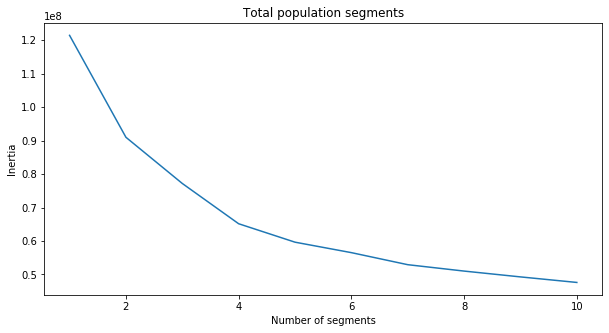

In [40]:
# Use elbow method to try to find appropriate number of clusters
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), [km.inertia_ for km in mods.values()])
plt.title('Total population segments')
plt.xlabel('Number of segments')
plt.ylabel('Inertia')
plt.show()

In [12]:
rmses = []
for i in range(1, 11):
    print(f"Working on {i}")
    samp_dat = seg_samp.copy()
    samp_dat['cluster'] = mods[i].labels_
    samp_prop = samp_dat.groupby('cluster')['cust_ind'].mean()

    full_dat = combo_clean.copy()
    full_dat['cluster'] = mods[i].predict(full_dat.iloc[:, :-1])
    full_prop = full_dat.groupby('cluster')['cust_ind'].mean()
    
    rmses.append(np.sqrt(sum((samp_prop - full_prop)**2/i)))


Working on 1
Working on 2
Working on 3
Working on 4
Working on 5
Working on 6
Working on 7
Working on 8
Working on 9
Working on 10


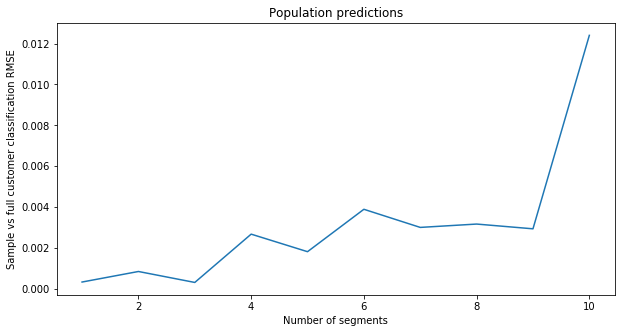

In [39]:
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), rmses)
plt.title('Population predictions')
plt.xlabel('Number of segments')
plt.ylabel('Sample vs full customer classification RMSE')
plt.show()

In [34]:
samp_dat = seg_samp.copy()
samp_dat['cluster'] = mods[5].labels_
samp_gb = samp_dat.groupby('cluster')['cust_ind']

samp_prop = samp_gb.mean()
samp_pop_share = samp_gb.count()/samp_dat.cust_ind.count()
samp_cust_share = samp_gb.sum()/samp_dat.cust_ind.sum()

full_dat = combo_clean.copy()
full_dat['cluster'] = mods[5].predict(full_dat.iloc[:, :-1])
full_gb = full_dat.groupby('cluster')['cust_ind']
full_prop = full_gb.mean()
full_pop_share = full_gb.count()/full_dat.cust_ind.count()
full_cust_share = full_gb.sum()/full_dat.cust_ind.sum()

pd.DataFrame({
    'samp_prop': samp_prop,
    'full_prop': full_prop,
    'samp_pop_share': samp_pop_share,
    'full_pop_share': full_pop_share,
    'samp_cust_share': samp_cust_share,
    'full_cust_share': full_cust_share
})


,samp_prop,full_prop,samp_pop_share,full_pop_share,samp_cust_share,full_cust_share
cluster,,,,,,
0,0.068781,0.069076,0.191350,0.190506,0.074502,0.074354
1,0.209889,0.210058,0.518263,0.518007,0.615758,0.614807
2,0.079005,0.082885,0.026884,0.027130,0.012023,0.012705
3,0.130435,0.129302,0.002804,0.002871,0.002070,0.002098
4,0.200337,0.200370,0.260699,0.261486,0.295647,0.296037


In [42]:
clusts = pd.DataFrame(mods[5].__dict__['cluster_centers_'])
clusts.columns = list(seg_samp.columns)[:-1]
vals = []
for col in clusts.columns:
    samp = clusts[col][[0, 1, 4]]
    sd = samp.std()
    mu = samp.mean()
    vals.append(sd/mu)

pd.DataFrame({
    'variable': clusts.columns,
    'cv': vals,
    'seg_1': round(clusts.iloc[0], 3),
    'seg_2': round(clusts.iloc[1], 3),
    'seg_5': round(clusts.iloc[4], 3),
}).sort_values('cv').to_csv("variables_segment.csv", index=False)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [16]:
import shap
import xgboost as xgb

from bayes_opt import BayesianOptimization
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

shap.initjs()

In [17]:
mailout_train = pd.read_csv(
    'data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)

In [18]:
# Pull out target variable
mo_y = mailout_train.RESPONSE
mo_X = mailout_train.drop('RESPONSE', axis=1)
# Split data
mo_X_trn, mo_X_tst, mo_y_trn, mo_y_tst = train_test_split(
    mo_X, mo_y, test_size=0.3,
    random_state=566664, stratify=mo_y)

In [19]:
# Clean up both inputs (note we use the training dataset's medians)
mo_X_trn_cln_bk, mo_X_meds = df_clean(mo_X_trn, var_eval)
mo_X_tst_cln_bk = df_clean(mo_X_tst, var_eval, mo_X_meds)[0]

In [20]:
# Hyperparameter ranges for tuning
param_bounds = {
    'eta': (0.01, 1.0),
    'n_estimators': (40, 150),
    'max_depth': (2, 6),
    'max_delta_step': (0, 5),
    'subsample': (0.5, 1.0),
    'lambd': (0, 1.5),
    'alpha': (0, 0.5),
    'scale_pos_weight': (40, 120)
}

In [21]:
# Function for use with the Bayesin Optimizer
def xgb_eval(
    eta, n_estimators, max_depth, max_delta_step, subsample, 
    lambd, alpha, scale_pos_weight):
    params={
        'verbosity': 0,
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        'eta': eta,
        'n_estimators': int(round(n_estimators, 0)),
        'max_depth': int(round(max_depth, 0)),
        'max_delta_step': int(round(max_delta_step, 0)),
        'subsample': subsample,
        'lambda': lambd,
        'alpha': alpha,
        'scale_pos_weight':scale_pos_weight,
    }
    xgb_cls = xgb.cv(params, mo_mat, nfold=5)
    return xgb_cls['test-auc-mean'].iloc[-1]

In [26]:
# Use separate file
drop_cols = pd.read_csv("col_drop.csv").feature.values
mo_X_trn_cln = mo_X_trn_cln_bk.drop(columns=drop_cols)
mo_X_tst_cln = mo_X_tst_cln_bk.drop(columns=drop_cols)
eval_set = [(mo_X_trn_cln, mo_y_trn, 'test'), (mo_X_tst_cln, mo_y_tst, 'eval')]
mo_mat = xgb.DMatrix(mo_X_trn_cln, label=mo_y_trn)

In [29]:
# Set up Bayesian Optimization
xg_bo = BayesianOptimization(xgb_eval, param_bounds) #, random_state=223074)

# Good parameter sets from prior runs to seed optimization
xg_bo.probe(params={
    'alpha': 0.4065,
    'eta': 0.2824,
    'lambd': 1.063,
    'max_delta_step': 3,
    'max_depth': 2,
    'n_estimators': 107,
    'scale_pos_weight':44.3,
    'subsample': .9047,
}, lazy=True)
xg_bo.probe(params={
    'alpha': 0.04821,
    'eta': 0.1759,
    'lambd': 0.1851,
    'max_delta_step': 3,
    'max_depth': 2,
    'n_estimators': 70,
    'scale_pos_weight': 40.26,
    'subsample': .7332,
}, lazy=True)
xg_bo.probe(params={ # Best so far
    'alpha': 0.45,
    'eta': 0.11,
    'lambd': 1.4,
    'max_delta_step': 5,
    'max_depth': 2,
    'n_estimators': 65,
    'scale_pos_weight': 44.3,
    'subsample': .75,
}, lazy=True)
# Current best
xg_bo.probe(params={
    'alpha': 0.0,
    'eta': 0.025,
    'lambd': 1.0,
    'max_delta_step': 5,
    'max_depth': 2,
    'n_estimators': 90,
    'scale_pos_weight': 45,
    'subsample': .75,
}, lazy=True)
xg_bo.probe(params={
    'alpha': 0.3976,
    'eta': 0.1822,
    'lambd': 1.492,
    'max_delta_step': 0,
    'max_depth': 2,
    'n_estimators': 60,
    'scale_pos_weight': 42.06,
    'subsample': .7763,
}, lazy=True)

# Run optimization
xg_bo.maximize(n_iter=20, init_points=4)

|   iter    |  target   |   alpha   |    eta    |   lambd   | max_de... | max_depth | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6225   |  0.4065   |  0.2824   |  1.063    |  3.0      |  2.0      |  107.0    |  44.3     |  0.9047   |
|  2        |  0.6347   |  0.04821  |  0.1759   |  0.1851   |  3.0      |  2.0      |  70.0     |  40.26    |  0.7332   |
|  3        |  0.6347   |  0.45     |  0.11     |  1.4      |  5.0      |  2.0      |  65.0     |  44.3     |  0.75     |
|  4        |  0.6306   |  0.0      |  0.025    |  1.0      |  5.0      |  2.0      |  90.0     |  45.0     |  0.75     |
|  5        |  0.6325   |  0.3976   |  0.1822   |  1.492    |  0.0      |  2.0      |  60.0     |  42.06    |  0.7763   |
|  6        |  0.6226   |  0.1327   |  0.7809   |  1.035    |  0.6069   |  2.768    |  80.72    |  43.05    |  0.9483   |
|  7        |  0.6292   

In [30]:
# Actually fit the model!
params_mod={
    'verbosity': 0,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'alpha': 0.0,
    'eta': 0.025,
    'lambda': 1.0,
    'max_delta_step': 5,
    'max_depth': 2,
    'n_estimators': 90,
    'scale_pos_weight': 45,
    'subsample': .75,
}
xg_mod = xgb.XGBClassifier(**params_mod)
xg_mod.fit(
    mo_X_trn_cln, mo_y_trn, 
    eval_set=eval_set, early_stopping_rounds=60)

# Get booster
xg_bst = xg_mod.get_booster()
# Need to remove gunk from bytearray to get v1.1 of XGBoost
# to play well with the Shap library
bst_bytearray = xg_bst.save_raw()[4:]
def xg_shap_hack(self=None):
    return bst_bytearray
xg_bst.save_raw = xg_shap_hack

[0]	validation_0-auc:0.60752	validation_1-auc:0.61018
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 60 rounds.
[1]	validation_0-auc:0.61691	validation_1-auc:0.61208
[2]	validation_0-auc:0.62306	validation_1-auc:0.61616
[3]	validation_0-auc:0.62518	validation_1-auc:0.61962
[4]	validation_0-auc:0.62823	validation_1-auc:0.63078
[5]	validation_0-auc:0.62766	validation_1-auc:0.62396
[6]	validation_0-auc:0.62950	validation_1-auc:0.63530
[7]	validation_0-auc:0.63404	validation_1-auc:0.63367
[8]	validation_0-auc:0.63387	validation_1-auc:0.63327
[9]	validation_0-auc:0.63279	validation_1-auc:0.63330
[10]	validation_0-auc:0.63617	validation_1-auc:0.63103
[11]	validation_0-auc:0.63650	validation_1-auc:0.63101
[12]	validation_0-auc:0.63894	validation_1-auc:0.63259
[13]	validation_0-auc:0.63899	validation_1-auc:0.63264
[14]	validation_0-auc:0.63909	validation_1-auc:0.62987
[15]	validation_0-auc:0.6393

In [33]:
# Feature names
feat_rnk = pd.DataFrame({'feature': mo_X_trn_cln.columns.values})
feat_dict = {
    'D19_KONSUMTYP_9': 'Inactive consumer',
    'D19_KONSUMTYP_3': 'Gourmet consumer',
    'HH_EINKOMMEN_SCORE': 'Household income score',
    'LP_FAMILIE_FEIN_1': 'Family type: single individual',
    'CAMEO_DEUG_2015': 'CAMEO social class ranking',
    'ALTER_HH': 'Age of primary householder',
    'ANZ_PERSONEN': 'People in household'
}
feat_rnk['feature_interp'] = [feat_dict[feat] for feat in feat_rnk.feature.values]

# Feature importance metrics
feat_rnk['splits'] = feat_rnk.feature.apply(lambda x: xg_bst.get_score(importance_type='weight').get(x, 0))
feat_rnk['avgGain'] = feat_rnk.feature.apply(lambda x: xg_bst.get_score(importance_type='gain').get(x, 0))
feat_rnk['totGain'] = feat_rnk.splits * feat_rnk.avgGain

feat_rnk.sort_values(['totGain', 'feature'], ascending=False)

,feature,feature_interp,splits,avgGain,totGain
4,D19_KONSUMTYP_9,Inactive consumer,41,372.882633,15288.187959
3,D19_KONSUMTYP_3,Gourmet consumer,29,413.718888,11997.847748
5,HH_EINKOMMEN_SCORE,Household income score,39,187.841027,7325.800066
6,LP_FAMILIE_FEIN_1,Family type: single individual,29,236.972194,6872.193637
2,CAMEO_DEUG_2015,CAMEO social class ranking,28,183.662817,5142.558863
0,ALTER_HH,Age of primary householder,25,191.585611,4789.640276
1,ANZ_PERSONEN,People in household,10,125.909250,1259.092499


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


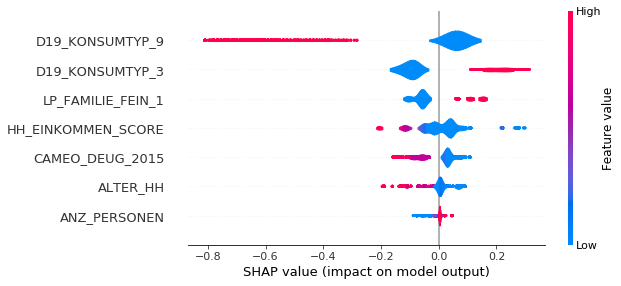

In [43]:
# Effect of features
explainer = shap.TreeExplainer(xg_bst)
shap_values = explainer.shap_values(mo_X_tst_cln)
shap.summary_plot(shap_values, mo_X_tst_cln, max_display=20, plot_type="violin")

In [44]:
# Prediction confusion matrix (OUCH!)
xg_pred = pd.DataFrame({
    'LNR': mo_X_tst.LNR,
    'score': xg_mod.predict(mo_X_tst_cln, output_margin=True),
    'pred': xg_mod.predict(mo_X_tst_cln, output_margin=False),
    'resp': mo_y_tst
})
print("Response rate by prediction")
print(xg_pred.groupby('pred')['resp'].mean())
print("Confusion matrix")
print(confusion_matrix(xg_pred.resp, xg_pred.pred))

Response rate by prediction
pred
0    0.011438
1    0.019698
Name: resp, dtype: float64
Confusion matrix
[[11236  1493]
 [  130    30]]


A real mixed bag here. The AUC is... okay. I'm mostly happy to have been able to get the overfitting under control. The response rate for what we're calling positives is up almost 50% vs the negatives, but I'm only catching 10% of respondents. In a situation like this, I'd almost certainly want to have placed a greater emphasis on recall unless this method is way too expensive.

The variables that made the cut were largely identified in the differences between existing customers and everyone else. There were some variables I expected to make it that didn't (e.g. energy consumption type). I think the real shocker for me is that single-person families were *more* likely to respond to the mailer. Maybe by also looking at the number of people in the household we got some strange marginal effect. 

## Part 3: Kaggle Competition ##

This part is fairly straightforward. I just need to pass the test data through the key steps of data prep and export it in the expected format. For those morbidly interested, [the leaderboard is here](https://www.kaggle.com/c/udacity-arvato-identify-customers/leaderboard#score).

In [45]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', 
                           sep=';', low_memory=False)

In [46]:
# Run it all at once
kag_x_cln = df_clean(mailout_test, var_eval, mo_X_meds)[0]
kag_x_cln.drop(columns=drop_cols, inplace=True)
kag_pred = pd.DataFrame({
    'LNR': mailout_test.LNR,
    'RESPONSE': xg_mod.predict(kag_x_cln, output_margin=True),
})
kag_pred.to_csv("kaggle_submission_2.csv", index=False)

And it's submitted! AUC of 0.62268 is good enough to put me near the bottom of the rankings. Definitely need to revisit this one! On the plus side, this matched my test metrics pretty closely, so I'm at least creating something that survives the trip into reality...